Here are the detailed instructions on how to complete the task.

First, install required libraries.

In [1]:
!pip install --upgrade pip
!pip install imutils
!pip install opencv-python
!pip install --upgrade scikit-learn==0.23.0

  Attempting uninstall: pip
    Found existing installation: pip 20.1
    Uninstalling pip-20.1:
      Successfully uninstalled pip-20.1


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Отказано в доступе: 'C:\\Users\\Adm\\AppData\\Local\\Temp\\pip-uninstall-gc2elcl_\\pip.exe'
Consider using the `--user` option or check the permissions.



  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


Import required libraries.

In [2]:
from IPython.display import Image
from imutils import paths
import numpy as np
import cv2
import os

To process images, obtain their histograms in order to find the intensity distribution. It can be done as follows.

In [3]:
def extract_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

Processing the images in the root folder ‘train’ and calculate the histogram for each image. Next, separate labels from images. Cloud processing of images takes time (1-5 minutes).

In [4]:
imagePaths = sorted(list(paths.list_images('train')))
trainData = []
labels = []

for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath, 1)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    hist = extract_histogram(image)
    trainData.append(hist)
    labels.append(label)

Convert the labels into the convenient format 0 and 1. Cat — 1 and Dog — 0.

In [5]:
Y = [1 if x == 'cat' else 0 for x in labels]

1


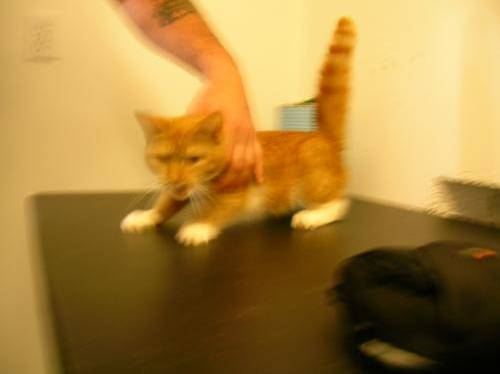

In [6]:
print(Y[0])
Image(filename=imagePaths[0])

First weak learner: bagging of decision trees

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=20, #максимальное число листьев
                              random_state=220)
bagging = BaggingClassifier(tree, #базовый алгоритм
                            n_estimators=19, #количество деревьев
                            random_state=220)
bagging.fit(trainData, Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_leaf_nodes=20,
                                                        min_samples_leaf=10,
                                                        random_state=220),
                  n_estimators=19, random_state=220)

Second weak learner: model of the almost separating hyperplane.

In [8]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state = 220, C = 1.74)
svm.fit(trainData, Y)

LinearSVC(C=1.74, random_state=220)

Third weak learner: random forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=19, #количество деревьев
                             criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=20, #максимальное число листьев
                              random_state=220)
forest.fit(trainData, Y)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=20,
                       min_samples_leaf=10, n_estimators=19, random_state=220)

Finally, metaalgorithm: logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', random_state=220)

In [11]:
from sklearn.ensemble import StackingClassifier

base_estimators = [('SVM', svm), ('Bagging DT', bagging), ('DecisionForest', forest)]
sclf = StackingClassifier(estimators=base_estimators, final_estimator=lr, cv=2)
sclf.fit(trainData, Y)

StackingClassifier(cv=2,
                   estimators=[('SVM', LinearSVC(C=1.74, random_state=220)),
                               ('Bagging DT',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                        max_leaf_nodes=20,
                                                                                        min_samples_leaf=10,
                                                                                        random_state=220),
                                                  n_estimators=19,
                                                  random_state=220)),
                               ('DecisionForest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_leaf_nodes=20,
                                                       min_samples_leaf=10,
       

Accuracy:

In [12]:
sclf.score(trainData, Y)

0.851

Calculate the predictions for an object in the test folder:

In [29]:
singleImage = cv2.imread('cat.1028.jpg')
histt = extract_histogram(singleImage)
histt2 = histt.reshape(1, -1)
prediction = sclf.predict(histt2)

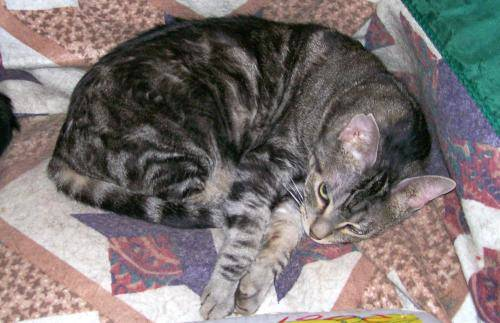

In [30]:
Image(filename='cat.1028.jpg')

In [31]:
prediction

array([0])

In [32]:
sclf.predict_proba(histt2)

array([[0.51493032, 0.48506968]])